In [7]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import math
import numpy as np
from scipy import stats

In [8]:
# HIDDEN

# Correlation coefficient
def corr(table, column_A, column_B):
    x = table[column_A]
    y = table[column_B]
    x_su = (x-np.mean(x))/np.std(x)
    y_su = (y-np.mean(y))/np.std(y)
    return np.mean(x_su*y_su)

## The regression line

The concepts of correlation and the "best" straight line through a scatter plot were developed in the late 1800's and early 1900's. The pioneers in the field were Sir Francis Galton, who was a cousin of Charles Darwin, and Galton's protégé Karl Pearson. Galton was interested in eugenics, and was a meticulous observer of the physical traits of parents and their offspring. Pearson, who had greater expertise than Galton in mathematics, helped turn those observations into the foundations of mathematical statistics. 

The scatter plot below is of a famous dataset collected by Pearson and his colleagues in the early 1900's. It consists of the heights, in inches, of 1,078 pairs of fathers and sons. 

The data are contained in the table ``heights``, in the columns ``father`` and ``son`` respectively. In the previous section, we saw how to use the table method ``scatter`` to draw scatter plots. Here, the method ``scatter`` in the ``pyplot`` module of ``matplotlib`` (imported as ``plots``) is used for the same purpose. The first argument of ``scatter`` is a array containing the variable on the horizontal axis. The second argument contains the variable on the vertical axis. The optional argument ``s=10`` sets the size of the points; the default value is ``s=20``.

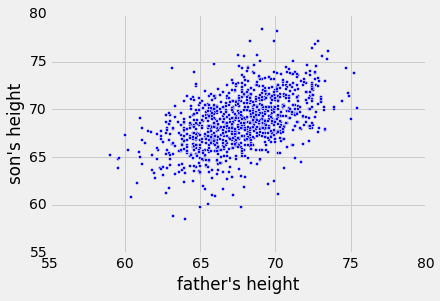

In [9]:
# Scatter plot using matplotlib method
heights = Table.read_table('heights.csv')
plots.scatter(heights['father'], heights['son'], s=10)
plots.xlabel("father's height")
plots.ylabel("son's height")
None

Notice the familiar football shape. This is characteristic of variable pairs that follow a *bivariate normal* distribution: the scatter plot is oval, the distribution of each variable is roughly normal, and the distribution of the variable in each vertical and horizontal strip is roughly normal as well.

The correlation between the heights of the fathers and sons is about 0.5.

In [10]:
r = corr(heights, 'father', 'son')
r

0.50116268080759108

###The regression effect
The figure below shows the scatter plot of the data when both variables are measured in standard units. As we saw earlier, the red line of equal standard units is too steep to serve well as the line of estimates of $y$ based on $x$. Rather, the estimates are on the green line, which is flatter and picks off the centers of the vertical strips.

This flattening was noticed by Galton, who had been hoping that exceptionally tall fathers would have sons who were just as exceptionally tall. However, the data were clear, and Galton realized that the tall fathers have sons who are not quite as exceptionally tall, on average. Frustrated, Galton called this phenomenon "regression to mediocrity." Because of this, the line of best fit through a scatter plot is called the *regression line*.

Galton also noticed that exceptionally short fathers had sons who were somewhat taller relative to their generation, on average. In general, individuals who are away from average on one variable are expected to be not quite as far away from average on the other. This is called the *regression effect*.

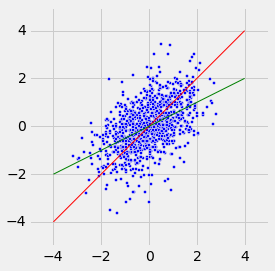

In [11]:
# The regression effect

f_su = (heights['father']-np.mean(heights['father']))/np.std(heights['father'])
s_su = (heights['son']-np.mean(heights['son']))/np.std(heights['son'])
plots.scatter(f_su, s_su, s=10)
plots.plot([-4, 4], [-4, 4], color='r', lw=1)
plots.plot([-4, 4], [-4*r, 4*r], color='g', lw=1)
plots.axes().set_aspect('equal')

The `Table` method ``scatter`` can be used with the option ``fit_line=True`` to draw the regression line through a scatter plot.

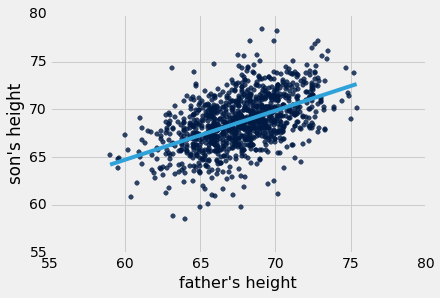

In [12]:
# Plotting the regression line, using Table

heights.scatter('father', fit_line=True)
plots.xlabel("father's height")
plots.ylabel("son's height")
None

Karl Pearson used the observation of the regression effect in the data above, as well as in other data provided by Galton, to develop the formal calculation of the correlation coefficient $r$. That is why $r$ is sometimes called *Pearson's correlation*.

###The equation of the regression line

As we saw in the last section for football shaped scatter plots, when the variables $x$ and $y$ are measured in standard units, the best straight line for estimating $y$ based on $x$ has slope $r$ and passes through the origin. Thus the equation of the regression line can be written as:

$~~~~~~~~~~$ estimate of $y$, in $y$-standard units $~=~$ 
$r ~ \times$ (the given $x$, in $x$-standard units)

That is,
$$
\frac{\mbox{estimate of}~y ~-~\mbox{average of}~y}{\mbox{SD of}~y}
~=~ r \times 
\frac{\mbox{the given}~x ~-~\mbox{average of}~x}{\mbox{SD of}~x}
$$

The equation can be converted into the original units of the data, either by rearranging this equation algebraically, or by labeling some important features of the line both in standard units and in the original units.

![regline](assets/images/regline.png)

It is a remarkable fact of mathematics that what we have observed to be true for football shaped scatter plots turns out to be true for all scatter plots, no matter what they look like.

**Regardless of the shape of the scatter plot**:

$$
\mbox{slope of the regression line} ~=~ \frac{r \cdot \mbox{SD of}~y}{\mbox{SD of}~x}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$$

$$
\mbox{intercept of the regression line} ~=~
\mbox{average of}~y ~-~ \mbox{slope} \cdot \mbox{(average of}~x\mbox{)}
$$

###Calculation of the slope and intercept

The NumPy method ``np.polyfit`` takes as its first argument an array consisiting of the values of the given variable; its second argument an array consisting of the variable to be estimated; its third argument ``deg=1`` specifies that we are fitting a straight line, that is, a polynomial of degree 1. It evaluates to an array consisting of the slope and the intercept of the regression line.

In [13]:
# Slope and intercept by NumPy method

np.polyfit(heights['father'], heights['son'], deg=1)

array([  0.51400591,  33.89280054])

It is worth noting that the intercept of approximately 33.89 inches is *not* intended as an estimate of the height of a son whose father is 0 inches tall. There is no such son and no such father. The intercept is merely a geometric or algebraic quantity that helps define the line. In general, it is not a good idea to *extrapolate*, that is, to make estimates outside the range of the available data. It is certainly not a good idea to extrapolate as far away as 0 is from the heights of the fathers in the study.

The calculations of the slope and intercept of the regression line are straightforward, so we will set ``np.polyfit`` aside and write our own function to compute the two quantities. The function ``regress`` takes as its arguments the name of the table, the column label of the given variable, and the column label of the variable to be estimated; it evaluates to an array containing the slope and the intercept of the regression line.

In [14]:
# Slope and intercept of regression line

def regress(table, column_x, column_y):
    r = corr(table, column_x, column_y)
    reg_slope = r*np.std(table[column_y])/np.std(table[column_x])
    reg_int = np.mean(table[column_y]) - reg_slope*np.mean(table[column_x])
    return np.array([reg_slope, reg_int])

A call to ``regress`` yields the same results as the call to ``np.polyfit`` made above.

In [15]:
slope_int_h = regress(heights, 'father', 'son')
slope_int_h

array([  0.51400591,  33.89280054])

## Fitted values
We can use the regression line to get an estimate of the height of every son in the data. The estimated values of $y$ are called the *fitted values*. They all lie on a straight line. To calculate them, take a son's height, multiply it by the slope of the regression line, and add the intercept. In other words, calculate the height of the regression line at the given value of $x$.

In [16]:
# Estimates of sons' heights are on the regression line

heights['fitted value'] = slope_int_h[0]*heights['father'] + slope_int_h[1]
heights

father,son,fitted value
65,59.8,67.3032
63.3,63.2,66.4294
65,63.3,67.3032
65.8,62.8,67.7144
61.1,64.3,65.2986
63,64.2,66.2752
65.4,64.1,67.5088
64.7,64,67.149
66.1,64.6,67.8686
67,64,68.3312


###Residuals

The amount of error in each of these regression estimates is the difference between the son's height and its estimate. These errors are called *residuals*. Some residuals are positive. These correspond to points that are above the regression line – points for which the regression line under-estimates $y$. Negative residuals correspond to the line over-estimating values of $y$.

In [17]:
# Error in the regression estimate: Distance between observed value and fitted value
# "Residual" 

heights['residual'] = heights['son'] - heights['fitted value']
heights

father,son,fitted value,residual
65,59.8,67.3032,-7.50318
63.3,63.2,66.4294,-3.22937
65,63.3,67.3032,-4.00318
65.8,62.8,67.7144,-4.91439
61.1,64.3,65.2986,-0.998562
63,64.2,66.2752,-2.07517
65.4,64.1,67.5088,-3.40879
64.7,64,67.149,-3.14898
66.1,64.6,67.8686,-3.26859
67,64,68.3312,-4.3312


As with deviations from average, the positive and negative residuals exactly cancel each other out. So the average (and sum) of the residuals is 0.

###Error in the regression estimate
Though the average residual is 0, each individual residual is not. Some residuals might be quite far from 0. To get a sense of the amount of error in the regression estimate, we will start with a graphical description of the sense in which the regression line is the "best".

Our example is a dataset that has one point for every chapter of the novel "Little Women." The goal is to estimate the number of characters (that is, letters, punctuation marks, and so on) based on the number of periods. Recall that we attempted to do this in the very first lecture of this course.

In [18]:
lw = Table.read_table('little_women.csv')

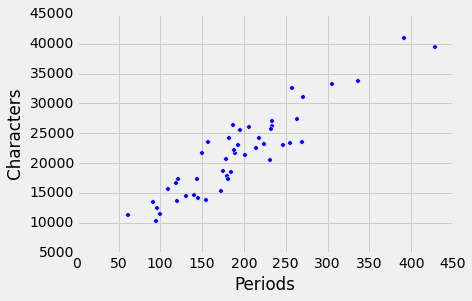

In [19]:
# One point for each chapter
# Horizontal axis: number of periods
# Vertical axis: number of characters (as in a, b, ", ?, etc; not people in the book)

plots.scatter(lw['Periods'], lw['Characters'])
plots.xlabel('Periods')
plots.ylabel('Characters')
None

In [20]:
corr(lw, 'Periods', 'Characters')

0.92295768958548163

The scatter plot is remarkably close to linear, and the correlation is more than 0.92.

In [21]:
a = [131, 14431]
b = [231, 20558]
c = [392, 40935]
d = [157, 23524]
def lw_errors(slope, intercept):
    xlims = np.array([50, 450])
    plots.scatter(lw['Periods'], lw['Characters'])
    plots.plot(xlims, slope*xlims + intercept, lw=2)
    plots.plot([a[0],a[0]], [a[1], slope*a[0] + intercept], color='r', lw=2)
    plots.plot([b[0],b[0]], [b[1], slope*b[0] + intercept], color='r', lw=2)
    plots.plot([c[0],c[0]], [c[1], slope*c[0] + intercept], color='r', lw=2)
    plots.plot([d[0],d[0]], [d[1], slope*d[0] + intercept], color='r', lw=2)
    plots.xlabel('Periods')
    plots.ylabel('Characters')

The figure below shows the scatter plot and regression line, with four of the errors marked in red.

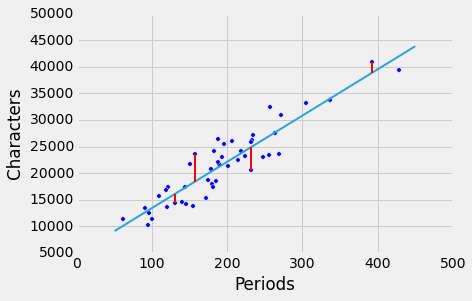

In [22]:
# Residuals: Deviations from the regression line

slope_int_lw = regress(lw, 'Periods', 'Characters')
lw_errors(slope_int_lw[0], slope_int_lw[1])

Had we used a different line to create our estimates, the errors would have been different. The picture below shows how big the errors would be if we were to use a particularly silly line for estimation.

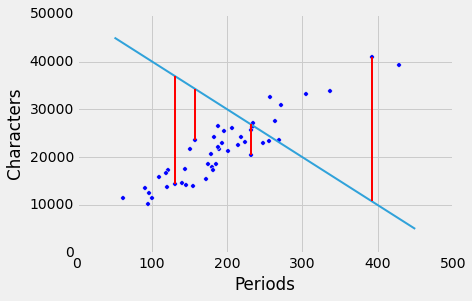

In [23]:
# Errors: Deviations from a different line

lw_errors(-100, 50000)

Below is a line that we have used before without saying that we were using a line to create estimates. It is the horizontal line at the value "average of $y$." Suppose you were asked to estimate $y$ and *were not told the value of $x$*; then you would use the average of $y$ as your estimate, regardless of the chapter. In other words, you would use the flat line below.

Each error that you would make would then be a deviation from average. The rough size of these deviations is the SD of $y$. 

In summary, if we use the flat line at the average of $y$ to make our estimates, the estimates will be off by the SD of $y$.

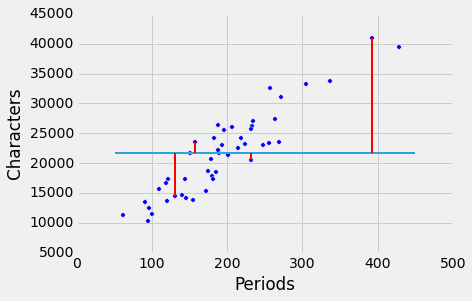

In [24]:
# Errors: Deviations from the flat line at the average of y

lw_errors(0, np.mean(lw['Characters']))

###The Method of Least Squares
If you use any arbitrary line as your line of estimates, then some of your errors are likely to be positive and others negative. To avoid cancellation when measuring the rough size of the errors, we take the mean of the sqaured errors rather than the mean of the errors themselves. This is exactly analogous to our reason for looking at squared deviations from average, when we were learning how to calculate the SD.

The mean squared error of estimation using a straight line is a measure of roughly how big the squared errors are; taking the square root yields the root mean square error, which is in the same units as $y$.

Here is the second remarkable fact of mathematics in this section: the regression line minimizes the mean squared error of estimation (and hence also the root mean squared error) among all straight lines. That is why the regression line is sometimes called the "least squares line."

**Computing the "best" line.**

- To get estimates of $y$ based on $x$, you can use any line you want.
- Every line has a mean squared error of estimation.
- "Better" lines have smaller errors.
- **The regression line is the unique straight line that minimizes the mean squared error of estimation among all straight lines.**

### Regression Functions

Regression is one of the most commonly used methods in statistics, and we will be using it frequently in the next few sections. It will be helpful to be able to call functions to compute the various quantities connected with regression. The first two of the functions below have already been defined; the rest are defined below.

- ``corr``: the correlation coefficient
- ``regress``: the slope and intercept of the regression line 
- ``fit``: the fitted value at one given value of $x$
- ``fitted_values``: the fitted values at all the values of $x$ in the data
- ``residuals``: the residuals
- ``scatter_fit``: scatter plot and regression line
- ``residual_plot``: plot of residuals versus $x$

In [25]:
# Correlation coefficient

def corr(table, column_A, column_B):
    x = table[column_A]
    y = table[column_B]
    x_su = (x-np.mean(x))/np.std(x)
    y_su = (y-np.mean(y))/np.std(y)
    return np.mean(x_su*y_su)

In [26]:
# Slope and intercept of regression line

def regress(table, column_x, column_y):
    r = corr(table, column_x, column_y)
    reg_slope = r*np.std(table[column_y])/np.std(table[column_x])
    reg_int = np.mean(table[column_y]) - reg_slope*np.mean(table[column_x])
    return np.array([reg_slope, reg_int])

In [27]:
# Fitted value; the regression estimate at x=new_x

def fit(table, column_x, column_y, new_x):
    slope_int = regress(table, column_x, column_y)
    return slope_int[0]*new_x + slope_int[1]

In [28]:
# Fitted values; the regression estimates lie on a straight line

def fitted_values(table, column_x, column_y):
    slope_int = regress(table, column_x, column_y)
    return slope_int[0]*table[column_x] + slope_int[1]

In [29]:
# Residuals: Deviations from the regression line

def residuals(table, column_x, column_y):
    fitted = fitted_values(table, column_x, column_y)
    return table[column_y] - fitted

In [30]:
# Scatter plot with fitted (regression) line

def scatter_fit(table, column_x, column_y):
    plots.scatter(table[column_x], table[column_y], s=10)
    plots.plot(table[column_x], fitted_values(table, column_x, column_y), lw=1, color='green')
    plots.xlabel(column_x)
    plots.ylabel(column_y)

In [31]:
# A residual plot

def residual_plot(table, column_x, column_y):
    plots.scatter(table[column_x], residuals(table, column_x, column_y), s=10)
    xm = np.min(table[column_x])
    xM = np.max(table[column_x])
    plots.plot([xm, xM], [0, 0], color='k', lw=1)
    plots.xlabel(column_x)
    plots.ylabel('residual')

## Residual plots

Suppose you have carried out the regression of sons' heights on fathers' heights.

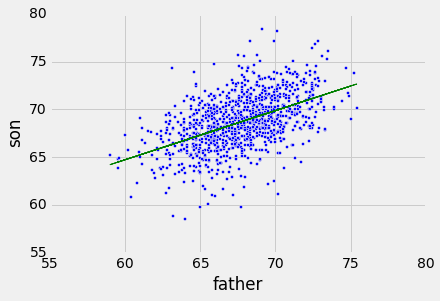

In [32]:
scatter_fit(heights, 'father', 'son')

It is a good idea to then draw a residual plot. This is a scatter plot of the residuals versus the values of $x$. The residual plot of a good regression looks like the one below: a formless cloud with no pattern, centered around the horizontal axis. It shows that there is no discernible non-linear pattern in the original scatter plot.

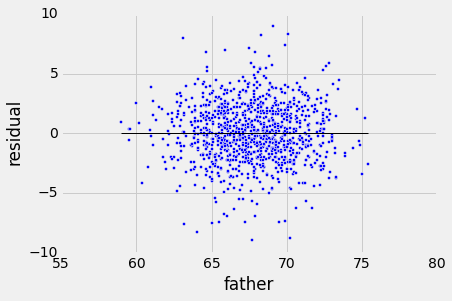

In [33]:
residual_plot(heights, 'father','son')

Residual plots can be useful for spotting non-linearity in the data, or other features that weaken the regression analysis. For example, consider the SAT data of the previous section, and suppose you try to estimate the ``Combined`` score based on ``Participation Rate``.

In [34]:
sat2014 = Table.read_table('sat2014.csv')
sat2014

State,Participation Rate,Critical Reading,Math,Writing,Combined
North Dakota,2.3,612,620,584,1816
Illinois,4.6,599,616,587,1802
Iowa,3.1,605,611,578,1794
South Dakota,2.9,604,609,579,1792
Minnesota,5.9,598,610,578,1786
Michigan,3.8,593,610,581,1784
Wisconsin,3.9,596,608,578,1782
Missouri,4.2,595,597,579,1771
Wyoming,3.3,590,599,573,1762
Kansas,5.3,591,596,566,1753


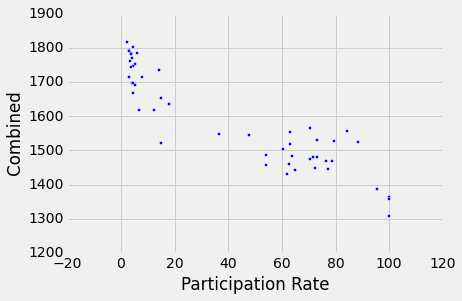

In [38]:
plots.scatter(sat2014['Participation Rate'], sat2014['Combined'], s=10)
plots.xlabel('Participation Rate')
plots.ylabel('Combined')
None

The relation between the variables is clearly non-linear, but you might be tempted to fit a straight line anyway, especially if you did not first draw the scatter diagram of the data.

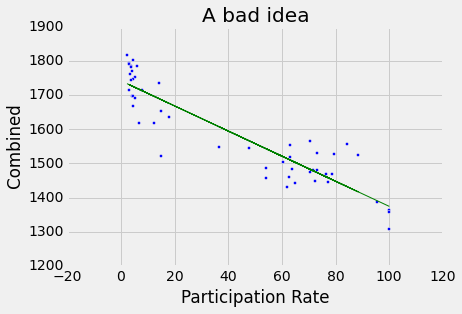

In [50]:
scatter_fit(sat2014, 'Participation Rate', 'Combined')
plots.title("A bad idea")
None

The points in the scatter plot start out above the regression line, then are consistently below the line, then above, then below. This pattern of non-linearity is more clearly visible in the residual plot.

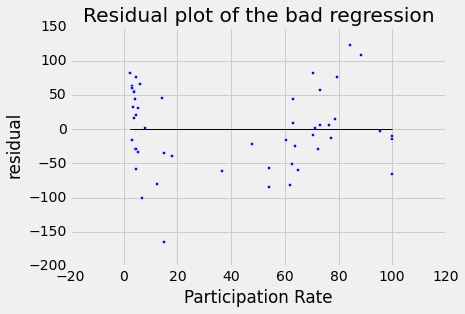

In [39]:
residual_plot(sat2014, 'Participation Rate', 'Combined')
plots.title('Residual plot of the bad regression')
None

This residual plot shows a non-linear pattern, and is a signal that linear regression should not have been used for these data.

###The rough size of the residuals
Let us return to the heights of the fathers and sons, and compare the estimates based on using the regression line and the flat line (in yellow) at the average height of the sons. As noted above, the rough size of the errors made using the flat line is the SD of $y$. Clearly, the regression line does a better job of estimating sons' heights than the flat line does; indeed, it minimizes the mean squared error among all lines. Thus, the rough size of the errors made using the regression line must be smaller that that using the flat line. In other words, the SD of the residuals must be smaller than the overall SD of $y$.

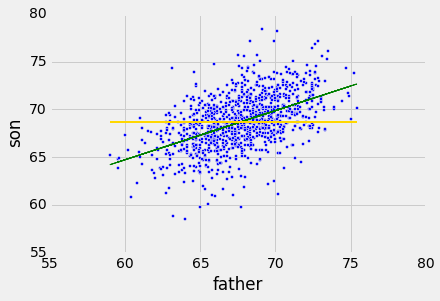

In [49]:
ave_y = np.mean(heights['son'])
scatter_fit(heights, 'father', 'son')
plots.plot([np.min(heights['father']), np.max(heights['father'])], [ave_y, ave_y], lw=2, color='gold')
None

Here, once again, are the residuals in the estimation of sons' heights based on fathers' heights. Each residual is the difference between the height of a son and his estimated (or "fitted") height.

In [41]:
heights

father,son,fitted value,residual
65,59.8,67.3032,-7.50318
63.3,63.2,66.4294,-3.22937
65,63.3,67.3032,-4.00318
65.8,62.8,67.7144,-4.91439
61.1,64.3,65.2986,-0.998562
63,64.2,66.2752,-2.07517
65.4,64.1,67.5088,-3.40879
64.7,64,67.149,-3.14898
66.1,64.6,67.8686,-3.26859
67,64,68.3312,-4.3312


The average of the residuals is 0. All the negative errors exactly cancel out all the positive errors.

The SD of the residuals is about 2.4 inches, while the overall SD of the sons' heights is about 2.7 inches. As expected, the SD of the residuals is smaller than the overall SD of $y$.

In [42]:
np.std(heights['residual'])

2.4358716091393409

In [43]:
np.std(heights['father'])

2.744553207672785

Smaller by what factor? Another remarkable fact of mathematics is that no matter what the data look like, the SD of the residuals is $\sqrt{1-r^2}$
times the SD of $y$.

In [44]:
np.std(heights['residual'])/np.std(heights['son'])

0.86535308826267487

In [45]:
np.sqrt(1 - r**2)

0.86535308826267476

###Average and SD of the Residuals
**Regardless of the shape of the scatter plot:**

average of the residuals = 0

SD of the residuals $~=~ \sqrt{1 - r^2} \cdot \mbox{SD of}~y$

The residuals are equal to the values of $y$ minus the fitted values. Since the average of the residuals is 0, the average of the fitted values must be equal to the average of $y$.

In the figure below, the fitted values are all on the green line segment. The center of that segment is at the point of averages, consistent with our calculation of the average of the fitted values.

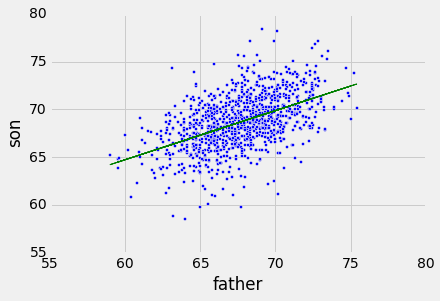

In [46]:
scatter_fit(heights, 'father', 'son')

The SD of the fitted values is visibly smaller than the overall SD of $y$. The fitted values range from about 64 to about 73, whereas the values of $y$ range from about 58 to 77.

So if we take the ratio of the SD of the fitted values to the SD of $y$, we expect to get a number between 0 and 1. And indeed we do: a very special number between 0 and 1.

In [47]:
np.std(heights['fitted value'])/np.std(heights['son'])

0.50116268080759108

In [48]:
r

0.50116268080759108

Here is the final remarkable fact of mathematics in this section:

###Average and SD of the Fitted Values
**Regardless of the shape of the scatter plot:**

average of the fitted values = the average of $y$

SD of the fitted values $~=~ |r| \cdot$ SD of $y$

Notice the absolute value of $r$ in the formula above. For the heights of fathers and sons, the correlation is positive and so there is no difference between using $r$ and using its absolute value. However, the result is true for variables that have negative correlation as well, provided we are careful to use the absolute value of $r$ instead of $r$.